# Gesture Recognition Case study Assignment

# Overview of the Project
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote. Let's have professor Raghavan introduce you to the problem statement:

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

- Thumbs up:  Increase the volume
- Thumbs down: Decrease the volume
- Left swipe: 'Jump' backwards 10 seconds
- Right swipe: 'Jump' forward 10 seconds  
- Stop: Pause the movie

Each video is a sequence of 30 frames (or images). In the next couple of lectures, our subject matter expert Snehansu will walk you through the structure of the dataset.

-----
# Objectives:

The key components of this gesture recognition project are likely:

**Input Data:** Videos of gestures, likely segmented into frames or clips.

**Feature Extraction:** Extract meaningful features using deep learning models.

**Model Training:** Train a deep learning model to classify gestures into categories.

**Evaluation:** Measure performance metrics like accuracy or F1-score.

-------


**Data Generator:**

…
**Evaluation and Write-Up:**

Clear documentation of steps, experiments, and decisions, including metrics to justify changes in the model architecture or preprocessing pipeline.


In [9]:
import numpy as np
import os
from PIL import Image
from imageio import imread
from skimage.transform import resize
import datetime
from keras import backend as K
import tensorflow as tf

np.random.seed(30)
import random as rn
rn.seed(30)
tf.random.set_seed(30)



# Steps in the Code

**Data Loading:**

Load images and corresponding labels based on train.csv and val.csv.
Images are resized to 64x64 pixels for consistent input size.

**Data Preprocessing:**

Normalize pixel values to a range of [0, 1].
Encode labels into numerical values using LabelEncoder.
Apply one-hot encoding to labels for compatibility with categorical_crossentropy loss.

**Data Augmentation:**

Enhance the dataset with transformations such as rotation, shift, zoom, and horizontal flip.

**CNN Model:**

The model includes:
Two convolutional layers for feature extraction.
Max pooling to reduce spatial dimensions.
Dropout for regularization.
Dense layers for classification.

**Training:**

Train the model using augmented data.
Validate on a separate validation dataset.

**Evaluation:**

Predictions are made on the validation set.
Evaluate performance using accuracy and classification report.

**Folder Structure**

The train and val folders contain subdirectories named by class labels (e.g., classname).
Each subdirectory contains images related to that class.

The CSV files (train.csv and val.csv) have columns:

classname: The name of the folder representing the class.

filename: The name of the image file.


In [10]:
import pandas as pd
import numpy as np

# Set seed for reproducibility
np.random.seed(30)

# Read the CSV files
train_data = pd.read_csv('/datasets/Project_data/train.csv', header=None)
val_data = pd.read_csv('/datasets/Project_data/val.csv', header=None)

train_path = '/datasets/Project_data/train'
val_path = '/datasets/Project_data/val'

train_doc = np.random.permutation(train_data[0].values)  
val_doc = np.random.permutation(val_data[0].values)

batch_size = 16  # Adjust based on memory capacity

# Check the data structure
print(train_data.head())
print(val_data.head())

# Extract labels
train_data['label'] = train_data[0].apply(lambda x: x.split(';')[-1].strip())
val_data['label'] = val_data[0].apply(lambda x: x.split(';')[-1].strip())

# Convert labels to integers (if necessary)
train_data['label'] = train_data['label'].astype(int)
val_data['label'] = val_data['label'].astype(int)

# Class distribution
train_class_counts = train_data['label'].value_counts()
val_class_counts = val_data['label'].value_counts()

print("Training Class Distribution:")
print(train_class_counts)

print("Validation Class Distribution:")
print(val_class_counts)

                                                   0
0  WIN_20180925_17_08_43_Pro_Left_Swipe_new;Left_...
1  WIN_20180925_17_18_28_Pro_Left_Swipe_new;Left_...
2  WIN_20180925_17_18_56_Pro_Left_Swipe_new;Left_...
3  WIN_20180925_17_19_51_Pro_Left_Swipe_new;Left_...
4  WIN_20180925_17_20_14_Pro_Left_Swipe_new;Left_...
                                                   0
0  WIN_20180925_17_17_04_Pro_Left_Swipe_new;Left_...
1  WIN_20180925_17_43_01_Pro_Left_Swipe_new;Left_...
2  WIN_20180925_18_01_40_Pro_Left_Swipe_new;Left_...
3  WIN_20180925_18_03_21_Pro_Left_Swipe_new;Left_...
4  WIN_20180926_16_46_22_Pro_Left_Swipe_new;Left_...
Training Class Distribution:
3    137
1    137
0    136
2    130
4    123
Name: label, dtype: int64
Validation Class Distribution:
1    23
2    22
3    21
0    18
4    16
Name: label, dtype: int64


In [11]:
# Check the length of train_doc and val_doc to make sure they have data
print(f"train_doc contains {len(train_doc)} sequences.")
print(f"val_doc contains {len(val_doc)} sequences.")

# Print out some example sequences to ensure they are valid
print(f"Example train_doc entry: {train_doc[0]}")
print(f"Example val_doc entry: {val_doc[0]}")

train_doc contains 663 sequences.
val_doc contains 100 sequences.
Example train_doc entry: WIN_20180926_16_54_08_Pro_Right_Swipe_new;Right_Swipe_new;1
Example val_doc entry: WIN_20180926_17_24_20_Pro_Thumbs_Down_new;Thumbs_Down_new;3


In [12]:
import numpy as np
import os
import imageio
from skimage.transform import resize

class ModelBuilder:
    def __init__(self, image_height=100, image_width=100, channels=3, num_classes=5, total_frames=30):
        self.image_height = image_height
        self.image_width = image_width
        self.channels = channels
        self.num_classes = num_classes
        self.total_frames = total_frames


    def generator(self, source_path, folder_list, batch_size, img_idx, x, y, z):
        print('Source path =', source_path, '; Batch size =', batch_size)
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t) // batch_size
            print(f"Total number of batches: {num_batches}")


            for batch in range(num_batches):
                batch_data = np.zeros((batch_size, len(img_idx), self.image_height, self.image_width, self.channels))  # Resize to 100x100
                batch_labels = np.zeros((batch_size, self.num_classes))
                print(f"Processing batch {batch + 1}/{num_batches}...")

                for folder in range(batch_size):
                    index = folder + (batch * batch_size)
                    folder_path = source_path + '/' + t[index].split(';')[0]

                    if not os.path.exists(folder_path):
                        print(f"Warning: Folder {folder_path} does not exist. Skipping.")
                        continue

                    imgs = os.listdir(folder_path)
                    if len(imgs) == 0:
                        print(f"Warning: No images found in folder {folder_path}. Skipping.")
                        continue

                    # Load the images and resize them
                    for idx, item in enumerate(img_idx):
                        img_path = folder_path + '/' + imgs[item]
                        image = imageio.imread(img_path).astype(np.float32)
                        image_resized = resize(image, (self.image_height, self.image_width), mode='constant', anti_aliasing=True)

                        # Normalize image channels
                        batch_data[folder, idx, :, :, 0] = (image_resized[:, :, 0] - np.mean(image_resized[:, :, 0])) / np.std(image_resized[:, :, 0])
                        batch_data[folder, idx, :, :, 1] = (image_resized[:, :, 1] - np.mean(image_resized[:, :, 1])) / np.std(image_resized[:, :, 1])
                        batch_data[folder, idx, :, :, 2] = (image_resized[:, :, 2] - np.mean(image_resized[:, :, 2])) / np.std(image_resized[:, :, 2])


                    # Assign one-hot encoded labels for each video
                    batch_labels[folder, int(t[index].strip().split(';')[2])] = 1

                yield batch_data, batch_labels




In [13]:
model_builder = ModelBuilder()
# Create a small list for testing
small_train_doc = train_doc[:10]  # Use the first 10 sequences for testing
small_train_generator = model_builder.generator(
    source_path=train_path, 
    folder_list=small_train_doc, 
    batch_size=2, 
    img_idx=list(range(30)),  # Assuming you want all frames
    x=0, y=0, z=0  # Replace x, y, z with actual values or remove them if unused
)


In [14]:
# Test the generator
for batch_data, batch_labels in small_train_generator:
    print(f"Batch data shape: {batch_data.shape}, Batch labels shape: {batch_labels.shape}")
    break  # Test one batch


steps_per_epoch = len(train_doc) // batch_size
if len(train_doc) % batch_size != 0:
    steps_per_epoch += 1  # Handle any leftover sequences

validation_steps = len(val_doc) // batch_size
if len(val_doc) % batch_size != 0:
    validation_steps += 1  # Handle any leftover validation sequences

print(f"steps_per_epoch: {steps_per_epoch}, validation_steps: {validation_steps}")

Source path = /datasets/Project_data/train ; Batch size = 2
Total number of batches: 5
Processing batch 1/5...
Batch data shape: (2, 30, 100, 100, 3), Batch labels shape: (2, 5)
steps_per_epoch: 42, validation_steps: 7


In [97]:
steps_per_epoch = len(train_doc) // batch_size
if len(train_doc) % batch_size != 0:
    steps_per_epoch += 1  # Handle any leftover sequences

validation_steps = len(val_doc) // batch_size
if len(val_doc) % batch_size != 0:
    validation_steps += 1  # Handle any leftover validation sequences

print(f"steps_per_epoch: {steps_per_epoch}, validation_steps: {validation_steps}")

steps_per_epoch: 42, validation_steps: 7


In [15]:
curr_dt_time = datetime.datetime.now()
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)
num_epochs = 20  
print('# training sequences =', num_train_sequences)
print('# validation sequences =', num_val_sequences)
print('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [16]:
print(f"Number of training documents: {len(train_doc)}")
print(f"First few entries in train_doc: {train_doc[:5]}")

Number of training documents: 663
First few entries in train_doc: ['WIN_20180926_16_54_08_Pro_Right_Swipe_new;Right_Swipe_new;1'
 'WIN_20180925_18_02_58_Pro_Thumbs_Down_new;Thumbs_Down_new;3'
 'WIN_20180925_17_33_08_Pro_Left_Swipe_new;Left_Swipe_new;0'
 'WIN_20180925_17_51_17_Pro_Thumbs_Up_new;Thumbs_Up_new;4'
 'WIN_20180926_17_17_35_Pro_Left_Swipe_new;Left_Swipe_new;0']


In [19]:
from keras.models import Sequential
from keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization, Activation
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from keras.layers import Conv3D, MaxPooling3D, GlobalAveragePooling3D, Dense, Dropout, BatchNormalization, Activation

# Define img_idx: Select all 30 frames
img_idx = list(range(30))  # Adjust as needed (e.g., subset of frames)


model = Sequential([
    Conv3D(32, (3, 3, 3), input_shape=(len(img_idx), 100, 100, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Activation('relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2, 2, 2)),

    Conv3D(64, (3, 3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Activation('relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2, 2, 2)),

    Conv3D(128, (3, 3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Activation('relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2, 2, 2)),

    GlobalAveragePooling3D(),
    Dense(256, activation='relu'),
    Dropout(0.7),  # Higher dropout
    Dense(5, activation='softmax')
])

# Data augmentation
def augment_images(img):
    if np.random.rand() > 0.5:
        img = np.fliplr(img)  # Random flip
    return img

# Integrate into the generator
def augment_frames(frames):
    return np.array([augment_images(frame) for frame in frames])



optimiser = optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 30, 100, 100, 32)  2624      
                                                                 
 activation_6 (Activation)   (None, 30, 100, 100, 32)  0         
                                                                 
 batch_normalization_6 (Batc  (None, 30, 100, 100, 32)  128      
 hNormalization)                                                 
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 15, 50, 50, 32)   0         
 3D)                                                             
                                                                 
 conv3d_7 (Conv3D)           (None, 15, 50, 50, 64)    55360     
                                                                 
 activation_7 (Activation)   (None, 15, 50, 50, 64)   

In [20]:
print(f"Number of training documents: {len(train_doc)}")
print(f"First few entries in train_doc: {train_doc[:5]}")

Number of training documents: 663
First few entries in train_doc: ['WIN_20180926_16_54_08_Pro_Right_Swipe_new;Right_Swipe_new;1'
 'WIN_20180925_18_02_58_Pro_Thumbs_Down_new;Thumbs_Down_new;3'
 'WIN_20180925_17_33_08_Pro_Left_Swipe_new;Left_Swipe_new;0'
 'WIN_20180925_17_51_17_Pro_Thumbs_Up_new;Thumbs_Up_new;4'
 'WIN_20180926_17_17_35_Pro_Left_Swipe_new;Left_Swipe_new;0']


Source path = /datasets/Project_data/train ; Batch size = 32
Total number of batches: 20
Processing batch 1/20...
Epoch 1/50
Processing batch 2/20...
19/20 [===========================>..] - ETA: 1s - loss: 1.1145 - categorical_accuracy: 0.9523Total number of batches: 20
Processing batch 1/20...
20/20 [==============================] - ETA: 0s - loss: 1.1099 - categorical_accuracy: 0.9547Processing batch 2/3...
Processing batch 3/3...
Total number of batches: 3
Processing batch 1/3...
Processing batch 2/3...

Epoch 00001: val_loss improved from inf to 1.56092, saving model to model_init_2024-12-0509_34_05.915191/model-00001-1.10994-0.95469-1.56092-0.68750.keras
20/20 [==============================] - 41s 2s/step - loss: 1.1099 - categorical_accuracy: 0.9547 - val_loss: 1.5609 - val_categorical_accuracy: 0.6875 - lr: 5.0000e-05
Epoch 2/50
Processing batch 2/20...
19/20 [===========================>..] - ETA: 1s - loss: 1.0789 - categorical_accuracy: 0.9638Total number of batches: 20
Pr

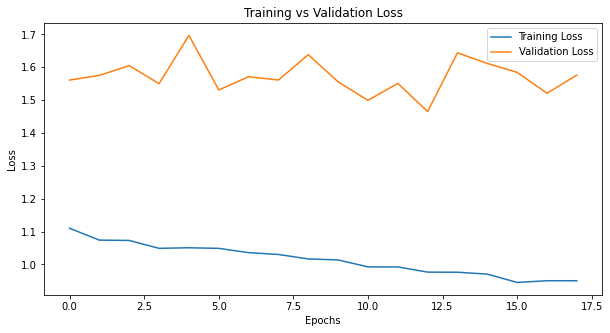

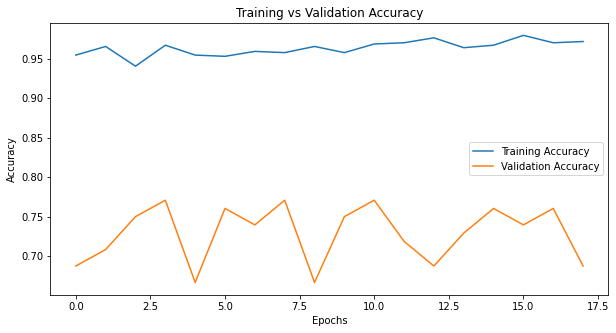

In [104]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Assume model_name and other variables are defined
model_name = "model_init_" + str(curr_dt_time).replace(" ", "").replace(":", "_") + "/"

# Early stopping setup
early_stopping = EarlyStopping(monitor='val_loss',    # Monitor validation loss
                               patience=5,            # Stop after 5 epochs of no improvement
                               verbose=1,             # Print a message when stopping
                               restore_best_weights=True)  # Restore the best weights when training stops

# ModelCheckpoint setup (for saving the best model)
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='auto')

# ReduceLROnPlateau setup (for dynamic learning rate adjustment)
LR = ReduceLROnPlateau(monitor='val_loss', 
                       factor=0.5, 
                       patience=5, 
                       verbose=1)


callbacks_list = [checkpoint, early_stopping, LR]

# Set your data parameters
batch_size = 32
img_idx = [0, 2, 4, 6, 8, 10, 12, 14]  # or adjust as needed


# Generate training and validation data using the generator
train_generator = model_builder.generator(train_path, train_doc, batch_size=batch_size, img_idx=img_idx, x=0, y=0, z=0)
val_generator = model_builder.generator(val_path, val_doc, batch_size=batch_size, img_idx=img_idx, x=0, y=0, z=0)

# Calculate steps per epoch and validation steps
steps_per_epoch = len(train_doc) // batch_size
validation_steps = len(val_doc) // batch_size


# Training the model
history=model.fit(
    train_generator,  # Use the train generator
    steps_per_epoch=steps_per_epoch,  # Number of steps per epoch
    epochs=50,  # Number of epochs (can adjust as needed)
    validation_data=val_generator,  # Validation data generator
    validation_steps=validation_steps,  # Number of validation steps
    verbose=1,  # Show progress
    callbacks=callbacks_list  # Callbacks to monitor training
)
# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

# Training vs Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

In [24]:
file_path = 'model-00013-0.97654-0.97656-1.46511-0.68750.keras'
file_path = 'model_init_2024-12-0509_34_05.915191/model-00013-0.97654-0.97656-1.46511-0.68750.keras'


In [25]:
from keras.models import load_model

model = load_model(file_path)
model

In [26]:
from tensorflow.keras.models import load_model
model.save('Pradeep-Gesture-Recognition-epoch13.h5')

In [28]:
import os
print("Saved files in current directory:", os.listdir('.'))

Saved files in current directory: ['.jarviscloud', '.ipython', 'dl_content', 'datasets', '.config', '.local', '.jupyter', 'Untitled.ipynb', '.ipynb_checkpoints', '.keras', 'model_init_2024-12-0507_16_34.260368', 'model_init_2024-12-0509_34_05.915191', '.cache', 'model_init_2024-12-05', 'Pradeep-Gesture-Recognition-epoch13.h5']


In [27]:
import os
saved_model_path = 'model_init_2024-12-0509_34_05.915191/'
print("Files in directory:", os.listdir(saved_model_path))


Files in directory: ['model-00001-3.35846-0.22969-2.93036-0.18750.keras', 'model-00002-3.00519-0.31094-2.90109-0.22917.keras', 'model-00003-2.84545-0.32188-2.87221-0.28125.keras', 'model-00004-2.74309-0.38281-2.86425-0.26042.keras', 'model-00006-2.67166-0.38438-2.86335-0.25000.keras', 'model-00009-2.47826-0.47500-2.85279-0.28125.keras', 'model-00012-2.37007-0.50469-2.81627-0.26042.keras', 'model-00013-2.31193-0.54062-2.80219-0.21875.keras', 'model-00014-2.25942-0.54688-2.78719-0.21875.keras', 'model-00015-2.16565-0.58438-2.67783-0.26042.keras', 'model-00018-2.05519-0.62031-2.63850-0.31250.keras', 'model-00019-2.03226-0.63594-2.59325-0.31250.keras', 'model-00021-1.88734-0.69844-2.48569-0.34375.keras', 'model-00022-1.90201-0.66719-2.39524-0.36458.keras', 'model-00023-1.83421-0.70000-2.33841-0.41667.keras', 'model-00024-1.76476-0.72656-2.21795-0.54167.keras', 'model-00029-1.55367-0.80469-2.14682-0.46875.keras', 'model-00030-1.56358-0.80781-2.01393-0.52083.keras', 'model-00034-1.43899-0.80

In [7]:
import os
os.makedirs('model_init_2024-12-05', exist_ok=True)